# Attention-based GRN Inference on Fine-tuned Model
Here we use the fine-tuned blood model on the Adamson perturbation dataset as an example of the cell-state specific GRN inference via attention weights. scGPT outputs attention weights on the individual cell level, which can be further aggregated by cell states. In this particular example, we compare the most influenced genes between a transcription factor repression condition (perturbed) and the control. However, this attention-based GRN inference is not restricted to perturbation-based discoveries. It can also be used to compare between cell states in general, such as healthy v.s. diseased, undifferentiated v.s. differentiated, as a broader application.

Users may perform scGPT's attention-based GRN inference in the following steps:

     1. Load fine-tuned scGPT model and data
     
     2. Retrieve scGPT's attention weights by condition (i.e., cell states)
     
     3. Perform scGPT's rank-based most influenced gene selection
     
     4. Validate the most influenced gene list against existing databases

NOTE in advance: to run this tutorial notebook, you may need to download the fine-tuned model from [link](https://drive.google.com/drive/folders/1HsPrwYGPXm867_u_Ye0W4Ch8AFSneXAn) and the list of targets of BHLHE40 from CHIP-Atlas for evaluation from [link](https://drive.google.com/drive/folders/1nc1LywRHlzt4Z17McfXiqBWgoGbRNyc0).

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import copy
import json
import os
from pathlib import Path
import sys
import warnings
import pickle

import torch
from anndata import AnnData
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import tqdm
import gseapy as gp
from gears import PertData, GEARS

from scipy.sparse import issparse
import scipy as sp
from einops import rearrange
from torch.nn.functional import softmax
from tqdm import tqdm
import pandas as pd

from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)

sys.path.insert(0, "../")

import scgpt as scg
from scgpt.tasks import GeneEmbedding
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.model import TransformerModel
from scgpt.utils import set_seed 
from scgpt.tokenizer import tokenize_and_pad_batch
from scgpt.preprocess import Preprocessor

os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

In [4]:
set_seed(42)
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
n_hvg = 1200
n_bins = 51
mask_value = -1
pad_value = -2
n_input_bins = n_bins

## Step 1: Load fine-tuned model and dataset

### 1.1  Load fine-tuned model

We are going to load a fine-tuned model for the gene interaction analysis on Adamson dataset. The fine-tuned model can be downloaded via this [link](https://drive.google.com/drive/folders/1HsPrwYGPXm867_u_Ye0W4Ch8AFSneXAn). The dataset will be loaded in the next step 1.2.

To reproduce the provided fine-tuned model. Please followw the integration fin-tuning pipeline to fine-tune the pre-trained blood model on the Adamson perturbation dataset. Note that in the fine-tuning stage, we did not perform highly vairable gene selection but trained on the 5000+ genes present in the Adamson dataset. This is to provide flexbility in the inference stage to investigate changes in attention maps across different perturbation conditions. 

In [5]:
# Specify model path; here we load the scGPT blood model fine-tuned on adamson
# model_dir = Path("../save/finetuned_scGPT_adamson")
model_dir = Path("/data4/zhuyiheng/wjl/scFM-Bench/data/weights/scgpt/scGPT_human")
model_config_file = model_dir / "args.json"
model_file = model_dir / "best_model.pt"
vocab_file = model_dir / "vocab.json"

vocab = GeneVocab.from_file(vocab_file)
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)

# Retrieve model parameters from config files
with open(model_config_file, "r") as f:
    model_configs = json.load(f)
print(
    f"Resume model from {model_file}, the model args will override the "
    f"config {model_config_file}."
)
embsize = model_configs["embsize"]
nhead = model_configs["nheads"]
d_hid = model_configs["d_hid"]
nlayers = model_configs["nlayers"]
n_layers_cls = model_configs["n_layers_cls"]

gene2idx = vocab.get_stoi()

Resume model from /data4/zhuyiheng/wjl/scFM-Bench/data/weights/scgpt/scGPT_human/best_model.pt, the model args will override the config /data4/zhuyiheng/wjl/scFM-Bench/data/weights/scgpt/scGPT_human/args.json.


In [5]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    pad_value=pad_value,
    n_input_bins=n_input_bins,
    use_fast_transformer=True,
)

try:
    model.load_state_dict(torch.load(model_file, map_location="cpu"))
    print(f"Loading all model params from {model_file}")
except:
    # only load params that are in the model and match the size
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_file, map_location="cpu")
    pretrained_dict = {
        k: v
        for k, v in pretrained_dict.items()
        if k in model_dict and v.shape == model_dict[k].shape
    }
    for k, v in pretrained_dict.items():
        print(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

model.to(device)

Loading params encoder.embedding.weight with shape torch.Size([60697, 512])
Loading params encoder.enc_norm.weight with shape torch.Size([512])
Loading params encoder.enc_norm.bias with shape torch.Size([512])
Loading params value_encoder.linear1.weight with shape torch.Size([512, 1])
Loading params value_encoder.linear1.bias with shape torch.Size([512])
Loading params value_encoder.linear2.weight with shape torch.Size([512, 512])
Loading params value_encoder.linear2.bias with shape torch.Size([512])
Loading params value_encoder.norm.weight with shape torch.Size([512])
Loading params value_encoder.norm.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.0.self_attn.Wqkv.weight with shape torch.Size([1536, 512])
Loading params transformer_encoder.layers.0.self_attn.Wqkv.bias with shape torch.Size([1536])
Loading params transformer_encoder.layers.0.self_attn.out_proj.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.0.self_attn.out

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): FlashTransformerEncoderLayer(
        (self_attn): FlashMHA(
          (Wqkv): Linear(in_features=512, out_features=1536, bias=True)
          (inner_attn): FlashAttention()
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=512, ou

### 1.2  Load dataset of interest
The Adamson perturbation dataset is retrieved from the GEARS package with the following code.

In [5]:
data_dir = Path("../data/GRN_analysis")
pert_data = PertData(data_dir)
pert_data.load(data_name="adamson")
adata = sc.read(data_dir / "adamson/perturb_processed.h5ad")
data_is_raw = False

Found local copy...
Found local copy...
Found local copy...
These perturbations are not in the GO graph and their perturbation can thus not be predicted
['SRPR+ctrl' 'SLMO2+ctrl' 'TIMM23+ctrl' 'AMIGO3+ctrl' 'KCTD16+ctrl']
Local copy of pyg dataset is detected. Loading...
Done!


In [5]:
# ori_batch_col = "control"
# adata.obs["celltype"] = adata.obs["condition"].astype("category")
# adata.obs["str_batch"] = adata.obs["control"].astype(str)
# adata.write_h5ad(data_dir / "adamson/adamson.h5ad")

In [ ]:
adata.var["id_in_vocab"] = [1 if gene in vocab else -1 for gene in adata.var["gene_name"]]
gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
adata = adata[:, adata.var["id_in_vocab"] >= 0]

In the scGPT workflow, we compare each TF perturbation condition with control one at a time. In each run, the data is subsetted to contain one TF and control only. In this example, we use the TF BHLHE40.

In [6]:
TF_name = 'BHLHE40'
adata = adata[adata.obs.condition.isin(['{}+ctrl'.format(TF_name), 'ctrl'])].copy()
np.unique(adata.obs.condition)

array(['BHLHE40+ctrl', 'ctrl'], dtype=object)

In [7]:
groups = adata.obs.groupby('condition').groups
groups

{'BHLHE40+ctrl': ['AAACGCTGAATCGC-1', 'AAACGCTGCACTTT-1', 'AAATCATGCCTTAT-1', 'AACAAACTCTACTT-1', 'AACCACGACTACGA-1', 'AACGCAACTATGGC-1', 'AACGGTACTCCGTC-1', 'AACGGTTGCATGAC-1', 'AACTCGGACTTATC-1', 'AACTCTTGCCTATT-1', 'AAGAAGACCCGTTC-1', 'AAGATGGATCGATG-1', 'AAGCAAGAGTCTAG-1', 'AAGCACTGCGGAGA-1', 'AAGCCATGATTCGG-1', 'AAGCCTGATATCTC-1', 'AAGCGACTCACACA-1', 'AAGCGACTCGCATA-1', 'AAGCGTACCACTTT-1', 'AAGGCTTGAAGAGT-1', 'AAGTAGGATTGCAG-1', 'AAGTCCGAACGTGT-1', 'AAGTCCGAGGAGTG-1', 'AAGTTCCTTCGATG-1', 'AATAAGCTACTGGT-1', 'AATCCGGAGAGATA-1', 'AATGAGGAAAAAGC-1', 'AATGCGTGGGATTC-1', 'AATGCGTGTGTGGT-1', 'AATGGCTGAGGTCT-1', 'AATGTAACTTCTGT-1', 'AATTACGAGTATCG-1', 'AATTCCTGACGCTA-1', 'AATTGATGTGGTGT-1', 'ACAAGAGACCGTAA-1', 'ACAATTGAGAAACA-1', 'ACACAGACTACTGG-1', 'ACACGAACCTAAGC-1', 'ACATTCTGAGGTTC-1', 'ACATTCTGTTCTCA-1', 'ACCACAGACCACCT-1', 'ACCAGCCTTTCTGT-1', 'ACCCAAGAAACGAA-1', 'ACCCAGCTATACCG-1', 'ACCCTCGATACGCA-1', 'ACCCTCGATTCCCG-1', 'ACCTCGTGTGCAGT-1', 'ACCTGAGACTGGTA-1', 'ACCTGAGATCACCC-1', 'A

We further pre-process the subsetted data following the scGPT pipeline.

In [22]:
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=3,  # step 1
    filter_cell_by_counts=False,  # step 2
    # normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    normalize_total=False,
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg= False,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata, batch_key="str_batch") #! batch_key for HVGs selection

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Filtering cells by counts ...
scGPT - INFO - Binning data ...


In [23]:
X_binned_wo_norm = adata.layers["X_binned"]
X_binned_wo_norm

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0, 31],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [17]:
X_binned_with_norm = adata.layers["X_binned"]
X_binned_with_norm

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0, 25],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [ ]:
#! 是否normalization对value binning是有影响的
(X_binned_wo_norm != X_binned_with_norm).sum()

17361941

In [33]:
sc.pp.highly_variable_genes(
    adata,
    layer=None,
    n_top_genes=1024,
    batch_key="str_batch",
    # batch_key="control",
    flavor="seurat_v3" if data_is_raw else "cell_ranger",
    subset=False,
)
#! 保证TF gene被保留下来
adata.var.loc[adata.var[adata.var.gene_name==TF_name].index, 'highly_variable'] = True
adata = adata[:, adata.var["highly_variable"]].copy()
print(adata)

AnnData object with n_obs × n_vars = 24767 × 1024
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name', 'celltype', 'str_batch', 'n_counts'
    var: 'gene_name', 'id_in_vocab', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20', 'hvg'
    obsm: 'bin_edges'
    layers: 'X_binned'


save selected gene list

In [34]:
with open(f"../data/GRN_analysis/adamson/{TF_name}_selected_gene_list_1024.txt", "w") as f:
    for gene in adata.var["gene_name"]:
        f.write(gene + "\n")

## Step 2: Retrieve scGPT's attention weights

### 2.1 Prepare model input

In [49]:
input_layer_key = "X_binned"
all_counts = (
    adata.layers[input_layer_key].A
    if issparse(adata.layers[input_layer_key])
    else adata.layers[input_layer_key]
)
genes = adata.var["gene_name"].tolist()
gene_ids = np.array(vocab(genes), dtype=int)

In [50]:
batch_size = 16
tokenized_all = tokenize_and_pad_batch(
    all_counts,
    gene_ids,
    max_len=len(genes)+1,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,  # append <cls> token at the beginning
    include_zero_gene=True,
)

In [51]:
all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]
src_key_padding_mask = all_gene_ids.eq(vocab[pad_token])
condition_ids = np.array(adata.obs["condition"].tolist())

### 2.1 Retrieve attention weights
Note that since the flash-attn package does not output attention scores, we manually calculate q @ k.T to extract the attention weights. Users may specify which layer to extract the attention weights from. In the manuscript, we used the attention weights from the last (12th) layer.

In [26]:
torch.cuda.empty_cache()
dict_sum_condition = {}

In [27]:
# Use this argument to specify which layer to extract the attention weights from
# Default to 11, extraction from the last (12th) layer. Note that index starts from 0
num_attn_layers = 11 

In [ ]:
model.eval()
with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):
    M = all_gene_ids.size(1)
    N = all_gene_ids.size(0)
    device = next(model.parameters()).device
    for i in tqdm(range(0, N, batch_size)):
        batch_size = all_gene_ids[i : i + batch_size].size(0)
        outputs = np.zeros((batch_size, M, M), dtype=np.float32)
        # Replicate the operations in model forward pass
        src_embs = model.encoder(torch.tensor(all_gene_ids[i : i + batch_size], dtype=torch.long).to(device))
        val_embs = model.value_encoder(torch.tensor(all_values[i : i + batch_size], dtype=torch.float).to(device))
        total_embs = src_embs + val_embs
        #! bn and dsbn NOT exist
        if getattr(model, "bn", None) is not None:
            total_embs = model.bn(total_embs.permute(0, 2, 1)).permute(0, 2, 1)
        # Send total_embs to attention layers for attention operations
        # Retrieve the output from second to last layer
        for layer in model.transformer_encoder.layers[:num_attn_layers]:
            total_embs = layer(total_embs, src_key_padding_mask=src_key_padding_mask[i : i + batch_size].to(device))
        # Send total_embs to the last layer in flash-attn
        # https://github.com/HazyResearch/flash-attention/blob/1b18f1b7a133c20904c096b8b222a0916e1b3d37/flash_attn/flash_attention.py#L90
        qkv = model.transformer_encoder.layers[num_attn_layers].self_attn.Wqkv(total_embs)
        # Retrieve q, k, and v from flast-attn wrapper
        qkv = rearrange(qkv, 'b s (three h d) -> b s three h d', three=3, h=8)
        q = qkv[:, :, 0, :, :]
        k = qkv[:, :, 1, :, :]
        v = qkv[:, :, 2, :, :]
        # https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a
        # q = [batch, gene, n_heads, n_hid]
        # k = [batch, gene, n_heads, n_hid]
        # attn_scores = [batch, n_heads, gene, gene]
        attn_scores = q.permute(0, 2, 1, 3) @ k.permute(0, 2, 3, 1)

        # Rank normalization by row
        attn_scores = attn_scores.reshape((-1, M))
        order = torch.argsort(attn_scores, dim=1)
        rank = torch.argsort(order, dim=1)
        attn_scores = rank.reshape((-1, 8, M, M))/M
        # Rank normalization by column
        attn_scores = attn_scores.permute(0, 1, 3, 2).reshape((-1, M))
        order = torch.argsort(attn_scores, dim=1)
        rank = torch.argsort(order, dim=1)
        attn_scores = (rank.reshape((-1, 8, M, M))/M).permute(0, 1, 3, 2)
        # Average 8 attention heads
        attn_scores = attn_scores.mean(1)
        
        outputs = attn_scores.detach().cpu().numpy()
        
        for index in range(batch_size):
            # Keep track of sum per condition
            c = condition_ids[i : i + batch_size][index]
            if c not in dict_sum_condition:
                dict_sum_condition[c] = outputs[index, :, :]
            else:
                dict_sum_condition[c] += outputs[index, :, :]

  0%|          | 0/1548 [00:00<?, ?it/s]

100%|██████████| 1548/1548 [15:22<00:00,  1.68it/s]


### 2.2 Average rank-normed attention weights by condition
In the previous step, we retrieve the attention weights for all cells and keep the running sum by condition (i.e., control, perturbed). We further calculate the mean here by dividing the number of cells per condition to obtain a gene * gene attention matrix for each condition.

In [30]:
dict_sum_condition_mean = dict_sum_condition.copy()
for i in groups.keys():
    dict_sum_condition_mean[i] = dict_sum_condition_mean[i]/len(groups[i])

In [31]:
pickle.dump(dict_sum_condition_mean, open('../data/GRN_analysis/adamson/scGPT_pretrain_sum_condition_mean_wo_norm.pkl', 'wb'))

In [ ]:
version = "wo_norm"
with open(f'../data/GRN_analysis/adamson/scGPT_pretrain_sum_condition_mean_{version}.pkl', 'rb') as f:
    dict_sum_condition_mean = pickle.load(f)
dict_sum_condition_mean['ctrl'].shape #! remove <cls> token?

(1201, 1201)

In [52]:
gene_vocab_idx = all_gene_ids[0].clone().detach().cpu().numpy()
gene_vocab_idx

array([60695, 30607, 10954, ..., 33212, 11394, 12288])

## Step pre-3: Load saved attention weights

In [78]:
model_name = 'scGPT'
# with open(f'../output/adamson/X/xTrimoGene/pretrain_attn_condition_mean_with_totalcounts.pkl', 'rb') as f:
with open(f'../output/adamson/X/{model_name}/pretrain_attn_condition_mean.pkl', 'rb') as f:
    dict_sum_condition_mean = pickle.load(f)

In [79]:
for k in dict_sum_condition_mean.keys():
    print(len(dict_sum_condition_mean[k]))

1024
1024
1024
1024


In [80]:
print(len(dict_sum_condition_mean["gene_ids"]))
dict_sum_condition_mean["gene_ids"][:10]

1024


array([30607, 10954, 33817, 29427, 33814, 31785, 33826, 21194,  8281,
        4603])

In [81]:
dict_sum_condition_mean["gene_names"][:10]

['SAMD11',
 'HES4',
 'TNFRSF18',
 'RP3-395M20.12',
 'TNFRSF14',
 'SMIM1',
 'TNFRSF9',
 'RERE',
 'EFHD2',
 'CELA2A']

## Step 3: Perform most influenced gene selection

In the manuscript, we proposed 3 settings for the most influenced gene selection, namely *Control*, *Perturb*, and *Difference*. In this example, we focus on the *Difference* setting to explore how the gene-gene network changes after perturbation compared to control.

In [82]:
np.where(np.array(dict_sum_condition_mean["gene_names"])==TF_name)[0][0]

204

In [83]:
def get_topk_most_influenced_genes(topk, setting):
    attn_top_gene_dict = {}
    attn_top_scores_dict = {}
    for i in groups.keys():
        if i != 'ctrl':
            knockout_gene = i.split('+')[0]
            # knockout_gene_idx = np.where(gene_vocab_idx==vocab([knockout_gene])[0])[0][0]
            knockout_gene_idx = np.where(np.array(dict_sum_condition_mean["gene_names"])==TF_name)[0][0]
            control = dict_sum_condition_mean['ctrl'][:, knockout_gene_idx]
            exp = dict_sum_condition_mean[i][:, knockout_gene_idx]
            # Chnage this line to exp, control, exp-control for three different settings
            if setting == 'difference':
                a = exp-control
            elif setting == 'control':
                a = control
            elif setting == 'perturbed':
                a = exp
            diff_idx = np.argpartition(a, -topk)[-topk:]
            scores = (a)[diff_idx]
            # attn_top_genes = vocab.lookup_tokens(gene_vocab_idx[diff_idx]) + [TF_name]
            attn_top_genes = list(np.array(dict_sum_condition_mean["gene_names"])[diff_idx]) + [TF_name]
            attn_top_gene_dict[i] = list(attn_top_genes)
            attn_top_scores_dict[i] = list(scores)
    return attn_top_gene_dict, attn_top_scores_dict

In [84]:
# Specify top k number of genes to be selected, and the selection setting
# Here calculate top 20 most influenced genes for CHIP-Atlas validation
topk = 20
setting = 'difference' # "control", "perturbed"
assert setting in ["difference", "control", "perturbed"]
attn_top_gene_dict_20, attn_top_scores_dict_20 = get_topk_most_influenced_genes(topk, setting)
print(attn_top_scores_dict_20[TF_name + '+ctrl'])
print(attn_top_gene_dict_20[TF_name + '+ctrl'])

[0.07993683, 0.08019477, 0.08097494, 0.0822407, 0.082145154, 0.081566304, 0.08235192, 0.08816552, 0.083577275, 0.093309164, 0.082386196, 0.08951515, 0.08385128, 0.09973234, 0.10095751, 0.08672869, 0.09207171, 0.10091472, 0.10138112, 0.09192443]
['PER2', 'AREG', 'NEAT1', 'BAZ2B', 'PPP1CB', 'CD69', 'NUMB', 'ATF6', 'ATF7IP2', 'RP1-187B23.1', 'AHCTF1', 'WWC2', 'TLK1', 'GAN', 'PHACTR1', 'STIM2', 'CLIP1', 'TOP2B', 'ZFR', 'PRR14L', 'BHLHE40']


<Figure size 1800x1800 with 0 Axes>

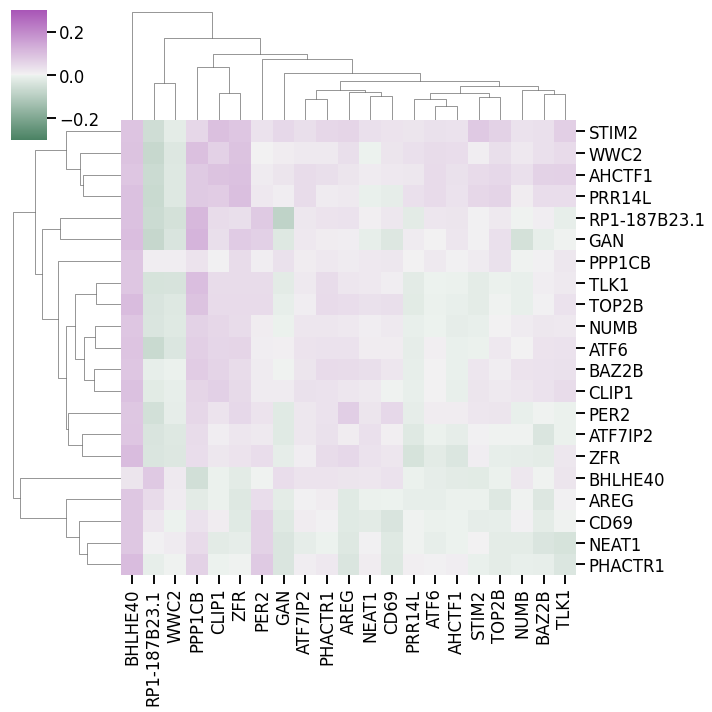

In [85]:
if setting == 'difference':
    for i in attn_top_gene_dict_20.keys():
        example_genes = attn_top_gene_dict_20[i]
        # gene_idx = [np.where(gene_vocab_idx==vocab([g])[0])[0][0] for g in example_genes]
        gene_idx = [np.where(np.array(dict_sum_condition_mean["gene_names"])==g)[0][0] for g in example_genes]
        scores = dict_sum_condition_mean[i][gene_idx, :][:, gene_idx]-dict_sum_condition_mean['ctrl'][gene_idx, :][:, gene_idx]
        df_scores = pd.DataFrame(data = scores, columns = example_genes, index = example_genes)
        plt.figure(figsize=(6, 6), dpi=300)
        ax = sns.clustermap(df_scores, annot=False, cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True), fmt='.2f', vmin=-0.3, vmax=0.3) 
        plt.show()
        plt.close()

In [87]:
# Specify top k number of genes to be selected, and the selection setting
# # Here calculate top 100 most influenced genes for pathway validation
topk = 100
setting = 'difference' # "control", "perturbed"
assert setting in ["difference", "control", "perturbed"]
attn_top_gene_dict_100, attn_top_scores_dict_100 = get_topk_most_influenced_genes(topk, setting)
print(attn_top_scores_dict_100[TF_name + '+ctrl'])
print(attn_top_gene_dict_100[TF_name + '+ctrl'])

[0.056022465, 0.056072593, 0.05621177, 0.057596028, 0.059669793, 0.060872555, 0.06584495, 0.06092602, 0.06511766, 0.061930895, 0.061074793, 0.056708694, 0.06710476, 0.063052595, 0.06453085, 0.06425655, 0.06027007, 0.06443578, 0.062043875, 0.062406033, 0.06426978, 0.05918026, 0.057789028, 0.06250405, 0.05988151, 0.056502044, 0.066171706, 0.058032215, 0.05820304, 0.065280974, 0.067174494, 0.058166802, 0.06644726, 0.06627238, 0.058419555, 0.05698192, 0.06098348, 0.062190622, 0.062956095, 0.06304705, 0.062322557, 0.058479846, 0.062047064, 0.059977055, 0.060090214, 0.06121844, 0.06240058, 0.05753559, 0.05917859, 0.06346494, 0.058115482, 0.0583663, 0.05987823, 0.065889955, 0.056728184, 0.0614236, 0.06772071, 0.06825495, 0.0706169, 0.10095751, 0.082386196, 0.0822407, 0.07114142, 0.09207171, 0.08235192, 0.07091856, 0.08385128, 0.09973234, 0.093309164, 0.069639266, 0.081566304, 0.08097494, 0.083577275, 0.06981897, 0.10138112, 0.09192443, 0.08816552, 0.0773204, 0.07704204, 0.07175839, 0.07993683

## Step 4: Validate most influenced genes

### Step 4.1: Validate against CHIP-Atlas

First load the tsv file from CHIP-Atlas containing targets of BHLHE40. The tsv file for BHLHE40 can be downloaded via this [link](https://drive.google.com/drive/folders/1nc1LywRHlzt4Z17McfXiqBWgoGbRNyc0). This tsv file was originally retrieved from the [CHIP-Atlas](https://chip-atlas.org/target_genes) website.

In [17]:
df = pd.read_csv('../data/GRN_analysis/BHLHE40.10.tsv', delimiter='\t')

Examine the overalp between the selected genes (top 20) and known target genes from the database.

In [94]:
def score_overlap_genes_by_rank(df, gene_list):
    target_genes = list(df['Target_genes'].values)
    total_targets = len(target_genes)
    gene_to_rank = {gene: rank for rank, gene in enumerate(target_genes)}  # 记录每个基因的排名

    overlap_genes = set(gene_list).intersection(set(target_genes))
    scores = {}

    for gene in overlap_genes:
        rank = gene_to_rank[gene]
        percentile = rank / total_targets
        if percentile < 0.2:
            scores[gene] = 5
        elif percentile < 0.4:
            scores[gene] = 4
        elif percentile < 0.6:
            scores[gene] = 3
        elif percentile < 0.8:
            scores[gene] = 2
        else:
            scores[gene] = 1

    return scores, sum(scores.values()), len(overlap_genes)

gene_list = attn_top_gene_dict_20[TF_name + '+ctrl'][:-1]
scores, total_score, num_overlap_genes = score_overlap_genes_by_rank(df, gene_list)
print("Individual scores:", scores)
print("Total score:", total_score) # max score is 5 * 20 = 100
print("Number of overlapping genes:", num_overlap_genes)

Individual scores: {'PER2': 5, 'STIM2': 3, 'PPP1CB': 3, 'GAN': 3, 'AHCTF1': 3, 'PRR14L': 3, 'BAZ2B': 1, 'CD69': 5, 'NUMB': 3, 'TLK1': 4, 'CLIP1': 2, 'AREG': 4, 'ATF6': 4, 'WWC2': 1, 'ZFR': 5, 'TOP2B': 5}
Total score: 54
Number of overlapping genes: 16


Visualize the network and strength of the edges (annotated with rank-normalized attention scores).

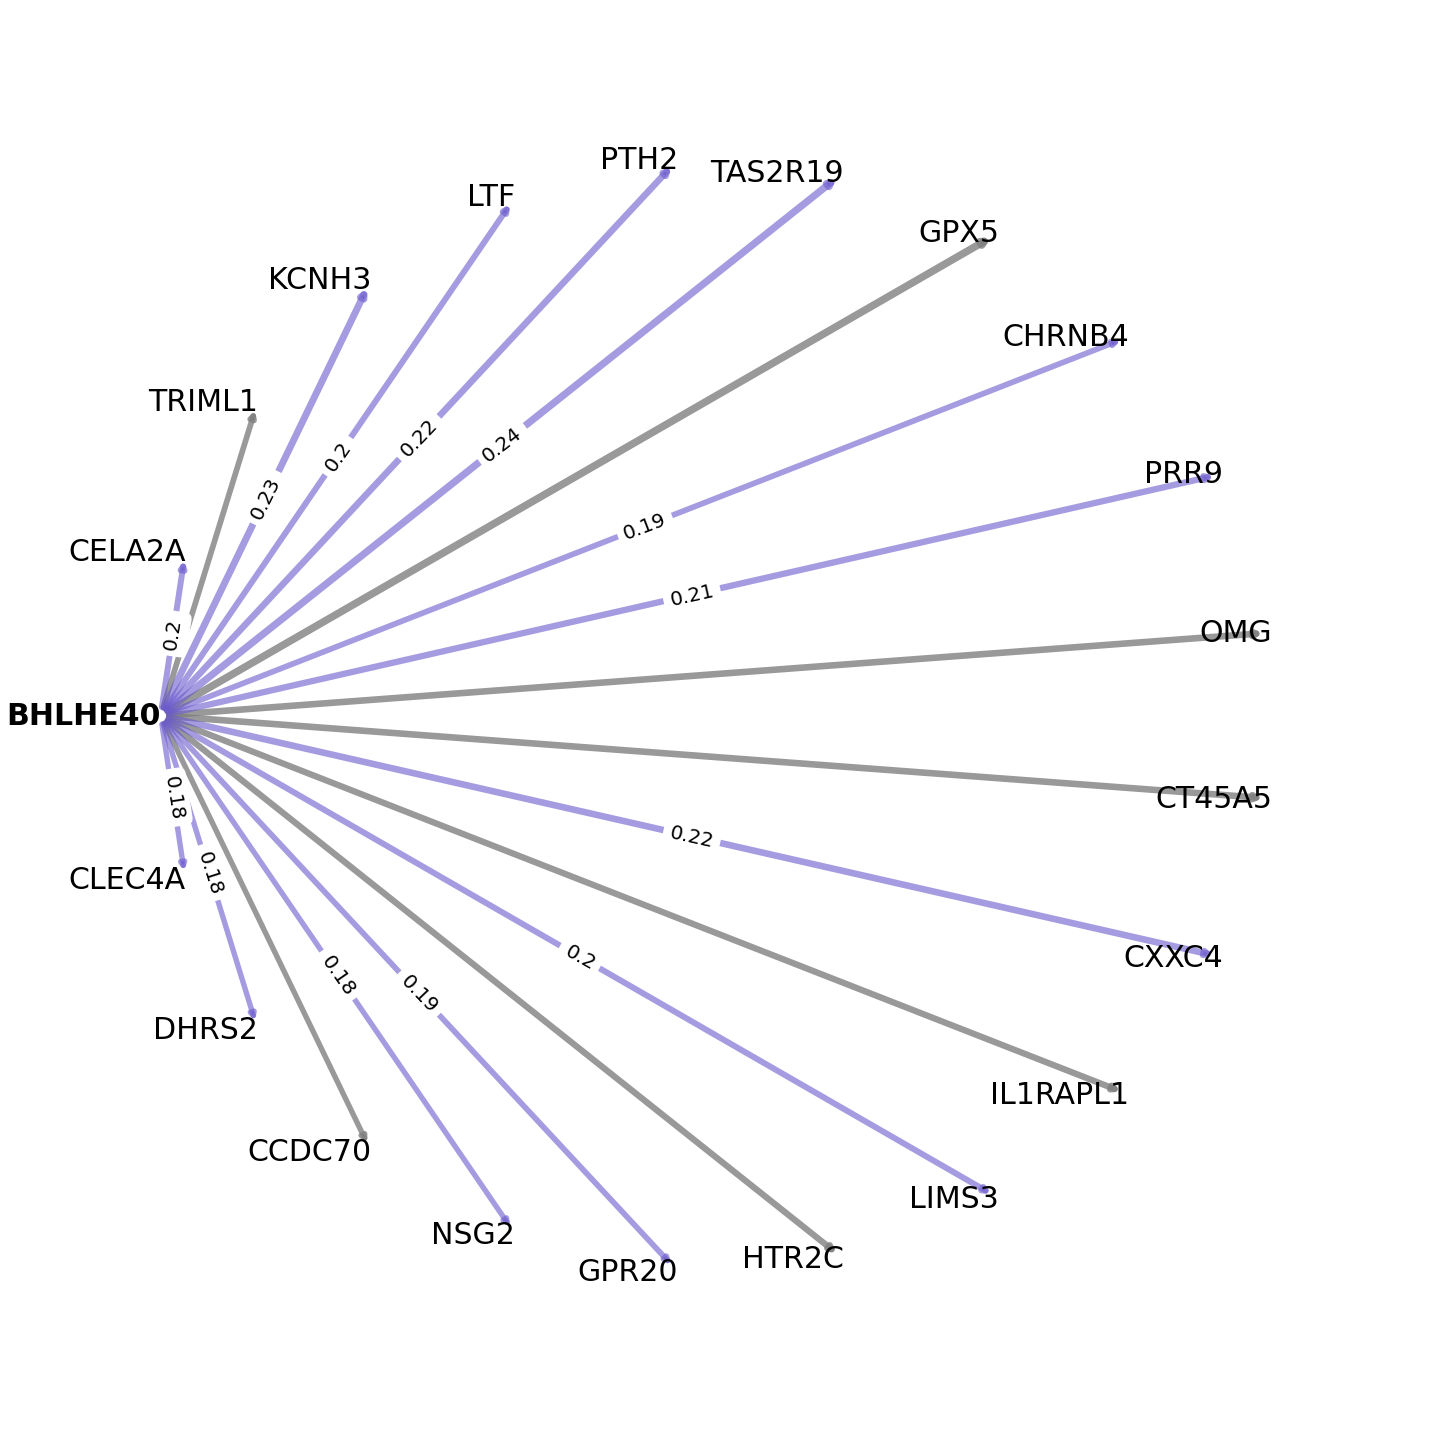

In [71]:
score_list = attn_top_scores_dict_20[TF_name + '+ctrl']
hits = set(gene_list).intersection(set(df['Target_genes'].values))

G = nx.DiGraph()
edge_list = [(TF_name, gene_list[i], round(score_list[i], 2)) for i in range(len(gene_list))]
G.add_weighted_edges_from(edge_list)

plt.figure(figsize=(20, 20))
edges = list(G.edges)
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if v in hits]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if v not in hits]
pos = nx.shell_layout(G)
width_large = {}
width_small = {}
for i, v in enumerate(edges):
    if v[1] in hits:
        width_large[edges[i]] = G.get_edge_data(v[0], v[1])['weight']*30
    else:
        width_small[edges[i]] = max(G.get_edge_data(v[0], v[1])['weight'], 0)*30
nx.draw_networkx_edges(G, pos,
                       edgelist = width_small.keys(),
                       width=list(width_small.values()),
                       edge_color='grey',
                       alpha=0.8)
nx.draw_networkx_edges(G, pos, 
                       edgelist = width_large.keys(), 
                       width = list(width_large.values()), 
                       alpha = 0.6, 
                       edge_color = "slateblue",
                      )
labels = {}
for i in pos.keys():
    if i == TF_name:
        labels[i] = ''
    else:
        labels[i] = i
        
labels1 = {}
for i in pos.keys():
    if i != TF_name:
        labels1[i] = ''
    else:
        labels1[i] = i
nx.draw_networkx_labels(G, pos, labels, font_size=30, font_family="sans-serif", horizontalalignment='right')
nx.draw_networkx_labels(G, pos, labels1, font_size=30, font_family="sans-serif", font_weight='bold', horizontalalignment='right')

d = nx.get_edge_attributes(G, "weight")
edge_labels = {k: d[k] for k in elarge}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=20)
ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()


#### Step 4.1.1: Try some new evaluation metrics

Text(0.5, 0, 'Fraction of top genes')

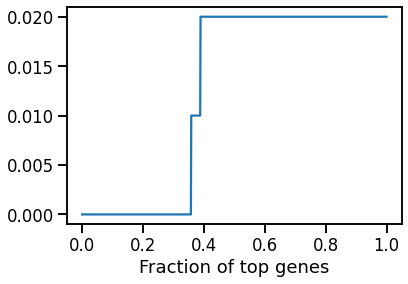

In [47]:
# Rank based metric
num_genes = dict_sum_condition_mean['ctrl'].shape[0]
target_genes = df['Target_genes'].values[:100]
x = []
y = []
for topk in range(1, num_genes+1):
    attn_top_gene_dict, _ = get_topk_most_influenced_genes(topk, setting)
    gene_list = attn_top_gene_dict[TF_name + '+ctrl'][:-1]
    x.append(topk/num_genes)
    overlap_genes = set(gene_list).intersection(set(target_genes))
    y.append(len(overlap_genes)/len(target_genes))
plt.plot(x, y)
plt.xlabel('Fraction of top genes')

Curve Area (AUC) = 0.0000


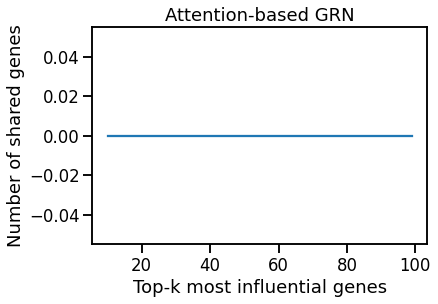

In [48]:
setting = 'difference' # "control", "perturbed"
x = np.arange(10, 100)
y = []
for topk in x:
    attn_top_gene_dict, _ = get_topk_most_influenced_genes(topk, setting)
    gene_list = attn_top_gene_dict[TF_name + '+ctrl'][:-1]
    overlap_genes = set(gene_list).intersection(set(df['Target_genes'].values[:topk]))
    all_genes = set(gene_list).union(set(df['Target_genes'].values[:topk]))
    # y.append(len(overlap_genes))
    # calculate jaccard similarity
    jaccard_similarity = len(overlap_genes) / len(all_genes)
    y.append(jaccard_similarity)

plt.plot(x, y)
plt.xlabel('Top-k most influential genes')
plt.ylabel('Number of shared genes')
plt.title('Attention-based GRN')

# calculate ROC
from sklearn.metrics import auc
# 计算 AUC（注意 x 和 y 都必须是 array 且 x 单调递增）
x = np.array(x)
x_scaled = (x - np.min(x)) / (np.max(x) - np.min(x))
y = np.array(y)
curve_auc = auc(x_scaled, y)
print(f"Curve Area (AUC) = {curve_auc:.4f}")

### Step 4.2:gene_list = attn_top_gene_dict_20[TF_name + '+ctrl'][:-1]
scores, total_score, num_overlap_genes = score_overlap_genes_by_rank(df, gene_list)
print("Individual scores:", scores)
print("Total score:", total_score) # max score is 5 * 20 = 100
print("Number of overlapping genes:", num_overlap_genes)

We perform pathway analysis on the top 100 most influenced genes by checking against the Reactome database. This replicates the reported pathways found in the *Difference* setting in the manuscript for the select TF.

In [20]:
# Validate with Reactome 
df_database = pd.DataFrame(
data = [['GO_Biological_Process_2021', 6036],
['GO_Molecular_Function_2021', 1274],
['Reactome_2022', 1818]],
columns = ['dataset', 'term'])
df_database

,dataset,term
0,GO_Biological_Process_2021,6036
1,GO_Molecular_Function_2021,1274
2,Reactome_2022,1818


In [21]:
databases = ['Reactome_2022']
m = df_database[df_database['dataset'].isin(databases)]['term'].sum() #df_database['term'].sum()
p_thresh = 0.05/((len(groups.keys())-1)*m) # 0.05/1818

In [88]:
gene_list = attn_top_gene_dict_100[TF_name + '+ctrl']
enr_Reactome = gp.enrichr(gene_list=gene_list,
                           gene_sets=databases,
                           organism='Human', 
                           outdir=f"../output/adamson/X/{model_name}/enrichr_Reactome_{TF_name}",
                           cutoff=0.1)

enr_Reactome.results.to_csv(f"../output/adamson/X/{model_name}/enrichr_Reactome_{TF_name}/enrichr_results.csv")
out = enr_Reactome.results
out['Gene List'] = str(gene_list)
print("Enrichment results for Reactome:", len(out))
out = out[out['P-value'] < p_thresh]
print("Significant enrichment results for Reactome:", len(out))
out

Enrichment results for Reactome: 474
Significant enrichment results for Reactome: 2


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Gene List
0,Reactome_2022,ATF4 Activates Genes In Response To Endoplasmi...,4/27,0.00001,0.004661,0,0,35.636038,410.877779,CEBPB;DDIT3;CCL2;ATF6,"['RP11-138A9.1', 'TET2', 'ASRGL1', 'LTN1', 'HB..."
1,Reactome_2022,PERK Regulates Gene Expression R-HSA-381042,4/32,0.00002,0.004683,0,0,29.265096,316.995431,CEBPB;DDIT3;CCL2;ATF6,"['RP11-138A9.1', 'TET2', 'ASRGL1', 'LTN1', 'HB..."


In [93]:
for i, row in df_database.iterrows():
    database, m = row['dataset'], row['term']
    p_thresh = 0.05/((len(groups.keys())-1)*m) # 0.05/1818
    gene_list = attn_top_gene_dict_100[TF_name + '+ctrl']
    enr_Reactome = gp.enrichr(gene_list=gene_list,
                              gene_sets=[database],
                              organism='Human', 
                              outdir=f"../output/adamson/X/{model_name}/enrichr_{database}_{TF_name}",
                              cutoff=0.1)

    enr_Reactome.results.to_csv(f"../output/adamson/X/{model_name}/enrichr_{database}_{TF_name}/enrichr_results.csv")
    out = enr_Reactome.results
    out['Gene List'] = str(gene_list)
    print(f"Enrichment results for {database}:", len(out))
    out = out[out['P-value'] < p_thresh]
    print(f"Significant enrichment results for {database}:", len(out))

Enrichment results for GO_Biological_Process_2021: 1242
Significant enrichment results for GO_Biological_Process_2021: 0
Enrichment results for GO_Molecular_Function_2021: 159
Significant enrichment results for GO_Molecular_Function_2021: 0
Enrichment results for Reactome_2022: 474
Significant enrichment results for Reactome_2022: 2
